In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd

import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

C:\Users\14\.conda\envs\pt\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
dat = pd.read_csv('data/data.csv', skiprows = [0, 1, 2, 3, 4, 5], encoding = 'cp949')
dat.head(5)

,날짜,지점,평균기온(℃),최저기온(℃),최고기온(℃)
0,2011-01-01,108,-6.8,-10.4,-2.9
1,2011-01-02,108,-5.4,-8.5,-1.2
2,2011-01-03,108,-4.5,-8.5,-0.3
3,2011-01-04,108,-3.9,-7.4,-1.7
4,2011-01-05,108,-4.0,-7.7,-1.8


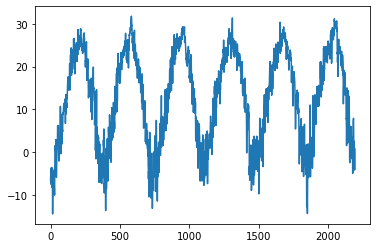

In [3]:
# 시각화
temp = dat['평균기온(℃)']

temp.plot()
plt.show()

In [4]:
# 데이터 집합을 훈련 데이터와 테스트 데이터로 분할
train_x = temp[:1461] # 2011.01.01 ~ 2014.12.31
test_x = temp[1461:] # 2015.01.01 ~ 2016.12.31

# numpy 배열 변환
train_x = np.array(train_x)
test_x = np.array(test_x)

In [6]:
# 독립변수 수
ATTR_SIZE = 180 # 6개월

tmp = []
train_X = []

# 데이터 점 1개 단위로 윈도우를 슬라이드 시키며 훈련 데이터를 추출
for i in range(0, len(train_x) - ATTR_SIZE):
    tmp.append(train_x[i:i+ATTR_SIZE])
train_X = np.array(tmp)

pd.DataFrame(train_X)

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,-6.8,-5.4,-4.5,-3.9,-4.0,-7.6,-7.0,-3.6,-7.0,-8.2,...,26.6,24.1,22.7,22.0,19.7,18.3,19.2,19.2,24.1,21.0
1,-5.4,-4.5,-3.9,-4.0,-7.6,-7.0,-3.6,-7.0,-8.2,-5.4,...,24.1,22.7,22.0,19.7,18.3,19.2,19.2,24.1,21.0,23.8
2,-4.5,-3.9,-4.0,-7.6,-7.0,-3.6,-7.0,-8.2,-5.4,-8.2,...,22.7,22.0,19.7,18.3,19.2,19.2,24.1,21.0,23.8,25.1
3,-3.9,-4.0,-7.6,-7.0,-3.6,-7.0,-8.2,-5.4,-8.2,-5.9,...,22.0,19.7,18.3,19.2,19.2,24.1,21.0,23.8,25.1,24.7
4,-4.0,-7.6,-7.0,-3.6,-7.0,-8.2,-5.4,-8.2,-5.9,-3.8,...,19.7,18.3,19.2,19.2,24.1,21.0,23.8,25.1,24.7,22.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1276,25.3,26.0,25.7,22.6,26.8,25.7,25.7,27.1,25.9,27.6,...,-9.0,-8.3,-3.8,-1.7,-6.4,-4.7,-1.3,1.7,-2.6,-3.2
1277,26.0,25.7,22.6,26.8,25.7,25.7,27.1,25.9,27.6,28.9,...,-8.3,-3.8,-1.7,-6.4,-4.7,-1.3,1.7,-2.6,-3.2,-1.8
1278,25.7,22.6,26.8,25.7,25.7,27.1,25.9,27.6,28.9,27.1,...,-3.8,-1.7,-6.4,-4.7,-1.3,1.7,-2.6,-3.2,-1.8,-0.8
1279,22.6,26.8,25.7,25.7,27.1,25.9,27.6,28.9,27.1,25.3,...,-1.7,-6.4,-4.7,-1.3,1.7,-2.6,-3.2,-1.8,-0.8,2.9


## 신경망 구성

In [8]:
# 신경망
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(180, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 128)
        self.fc4 = nn.Linear(128, 180)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = Net()

## 모형 학습

In [11]:
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(1000):
    
    total_loss = 0
    d = []
    
#     훈련 데이터를 미니배치로 분할
    for i in range(100):
#         훈련 데이터에 인덱스 부여
        index = np.random.randint(0, 1281)
#         미니배치 분할
        d.append(train_X[index])
#     numpy 배열 변환
    d = np.array(d, dtype = 'float32')
    d = Variable(torch.from_numpy(d))
    
    optimizer.zero_grad()
    output = model(d)
    loss = criterion(output, d)
    loss.backward()
    optimizer.step()
    total_loss += loss.data
    
    if (epoch+1) % 100 == 0:
        print(epoch+1, total_loss)

100 tensor(8.2196)
200 tensor(8.0921)
300 tensor(8.4443)
400 tensor(7.6169)
500 tensor(6.4537)
600 tensor(5.6963)
700 tensor(5.6632)
800 tensor(5.0946)
900 tensor(4.9948)
1000 tensor(4.5163)


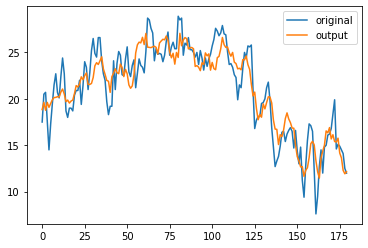

In [12]:
plt.plot(d.data[0].numpy(), label = 'original')
plt.plot(output.data[0].numpy(), label = 'output')
plt.legend(loc='upper right')
plt.show()

## 이상 점수 계산

In [23]:
tmp = []
test_X = []

# 테스트 데이터를 6개월 단위로 분할
tmp.append(test_x[0:180])
tmp.append(test_x[180:360])
tmp.append(test_x[360:540])
tmp.append(test_x[540:720])
test_X = np.array(tmp, dtype = 'float32')

pd.DataFrame(test_X)

,0,1,2,3,4,5,6,7,8,9,...,170,171,172,173,174,175,176,177,178,179
0,-7.7,-6.000000,-2.700000,2.500000,3.700000,-3.200000,-5.500000,-5.1,-2.1,-0.3,...,19.600000,22.4,24.0,24.700001,25.700001,24.799999,21.000000,25.200001,25.400000,25.700001
1,24.4,23.700001,23.700001,23.299999,24.100000,24.200001,25.299999,25.6,23.4,26.5,...,-4.600000,-3.3,-0.1,1.500000,2.200000,3.100000,5.900000,1.500000,-0.800000,0.900000
2,-5.7,-5.700000,-3.200000,0.300000,0.700000,1.200000,5.700000,6.5,2.0,-2.7,...,23.799999,20.9,20.9,23.799999,24.500000,24.100000,24.700001,26.000000,24.299999,24.700001
3,23.1,22.799999,24.400000,24.400000,24.700001,25.299999,24.600000,24.0,23.5,23.5,...,-1.100000,2.3,3.4,-1.400000,-5.000000,-4.700000,2.700000,4.900000,7.200000,7.600000


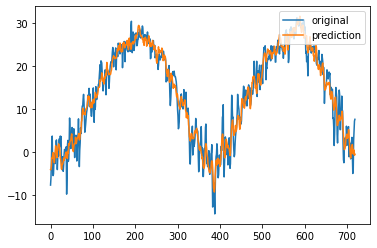

In [24]:
# 모형 적용
d = Variable(torch.from_numpy(test_X))
output = model(d)

plt.plot(test_X.flatten(), label = 'original')
plt.plot(output.data.numpy().flatten(), label = 'prediction')
plt.legend(loc='upper right')
plt.show()

In [34]:
# 이상 점수 계산
test = test_X.flatten()
pred = output.data.numpy().flatten()

total_score = []
for i in range(0, 720):
    dist = (test[i] - pred[i])
    score = pow(dist, 2)
    total_score.append(score)
    
# 이상 점수를 [0, 1] 구간으로 정규화
total_score = np.array(total_score)
max_score = np.max(total_score)
total_score = total_score / max_score

total_score

array([1.54148484e-01, 4.60283284e-02, 3.51464084e-03, 1.82771258e-01,
       3.13053929e-01, 8.26414821e-02, 3.43244581e-01, 1.64306087e-01,
       2.51253051e-03, 5.92186160e-02, 7.84026578e-03, 9.04806917e-02,
       1.85752306e-02, 3.09321956e-02, 9.11771905e-02, 5.43864694e-02,
       2.43512877e-01, 3.50213689e-02, 2.77928763e-02, 9.40300709e-02,
       1.01853361e-02, 3.41355443e-02, 6.55876330e-03, 3.07721636e-01,
       2.75976810e-01, 4.92577065e-01, 2.09875289e-03, 1.09945040e-02,
       3.99135208e-02, 4.47731430e-03, 6.08607772e-02, 3.08543884e-02,
       2.23954998e-02, 4.62708890e-02, 4.27554142e-02, 4.40445968e-03,
       1.18593141e-02, 1.74257764e-02, 9.05211684e-01, 2.31773432e-01,
       1.24068414e-01, 7.70110968e-02, 4.54786101e-02, 1.50709423e-01,
       2.71896858e-03, 4.47674861e-01, 7.38817338e-02, 5.62565565e-03,
       5.01964560e-02, 2.73147774e-02, 1.16655311e-02, 8.51555577e-02,
       7.39499935e-02, 2.83486035e-03, 4.79436162e-02, 2.06760571e-01,
      

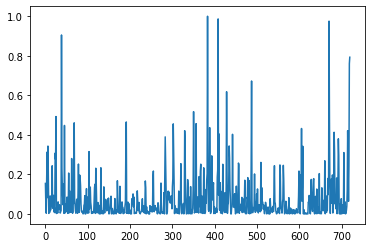

In [35]:
plt.plot(total_score)
plt.show()